- This notebook shows for different surveys the constraints on the 3D morphology of ELG (Emission-Line Galaxies), LRG (Luminous Red Galaxies) -DESI data- and CMASS galaxies derived from their projected shapes (galaxy catalogues matched with UNIONS shapes)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.coordinates import concatenate
from astropy import units as u

from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation

import treecorr
import random

import torch
from torch.distributions import Uniform

from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

import corner

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download the different matched catalogues for analysis

In [3]:
# CMASS-UNIONS

unions_cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_cmass_cross.fits')

names = [name for name in unions_cmass_table.colnames if len(unions_cmass_table[name].shape) <= 1]
filtered_tbl = unions_cmass_table[names]

unions_cmass_cross = filtered_tbl.to_pandas()
unions_cmass_cross.columns

nb_unions_cmass = len(unions_cmass_cross) ; print(nb_unions_cmass)

unions_cmass_index = unions_cmass_cross.index
unions_cmass_index=np.array(unions_cmass_index)

210440


In [4]:
# ELG-UNIONS

unions_elg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_elg_cross.fits')

names = [name for name in unions_elg_table.colnames if len(unions_elg_table[name].shape) <= 1]
filtered_tbl = unions_elg_table[names]

unions_elg_cross = filtered_tbl.to_pandas()
unions_elg_cross.columns

nb_unions_elg = len(unions_elg_cross) ; print(nb_unions_elg)

unions_elg_index = unions_elg_cross.index
unions_elg_index=np.array(unions_elg_index)

243544


In [5]:
# LRG-UNIONS

unions_lrg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/unions_desi_lrg_catalogue.fits')

names = [name for name in unions_lrg_table.colnames if len(unions_lrg_table[name].shape) <= 1]
filtered_tbl = unions_lrg_table[names]

unions_lrg_cross = filtered_tbl.to_pandas()
unions_lrg_cross.columns

nb_unions_lrg = len(unions_lrg_cross) ; print(nb_unions_lrg)

unions_lrg_index = unions_lrg_cross.index

329819


In [6]:
# LRG+ELG-UNIONS

unions_lrg_elg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/unions_desi_lrg+elg_catalogue.fits')

names = [name for name in unions_lrg_elg_table.colnames if len(unions_lrg_elg_table[name].shape) <= 1]
filtered_tbl = unions_lrg_elg_table[names]

unions_lrg_elg_cross = filtered_tbl.to_pandas()
unions_lrg_elg_cross.columns

nb_unions_lrg_elg = len(unions_lrg_elg_cross) ; print(nb_unions_lrg_elg)

unions_lrg_elg_index = unions_lrg_elg_cross.index

595516


In [7]:
# Somes functions required for further work

def get_galaxy_orientation_angle(e1,e2):
    return 0.5*np.arctan2(e2,e1)

def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e  

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

### Computation of the summary statistics

In [8]:
# CMASS-UNIONS

a = np.zeros(len(unions_cmass_cross))
b = np.zeros(len(unions_cmass_cross))
theta = np.zeros(len(unions_cmass_cross))
axis_ratio_cmass = np.zeros(len(unions_cmass_cross))
e1cmass = np.zeros(len(unions_cmass_cross))
e2cmass = np.zeros(len(unions_cmass_cross))
ecmass = np.zeros(len(unions_cmass_cross))

e1_values = unions_cmass_cross['e1'][unions_cmass_index]
e2_values = unions_cmass_cross['e2'][unions_cmass_index]

a, b = np.vectorize(a_b)(e1_values, e2_values)
axis_ratio_cmass = a / b

theta = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
e1cmass, e2cmass = np.vectorize(e_complex)(a, b, theta)

e_cmass = np.vectorize(abs_e)(e1cmass, e2cmass)

np.std(e1cmass)

0.16663218892837026

In [9]:
# ELG-UNIONS

a = np.zeros(len(unions_elg_cross))
b = np.zeros(len(unions_elg_cross))
theta = np.zeros(len(unions_elg_cross))
axis_ratio_lrg = np.zeros(len(unions_elg_cross))
e1lrg = np.zeros(len(unions_elg_cross))
e2lrg = np.zeros(len(unions_elg_cross))
elrg = np.zeros(len(unions_elg_cross))

e1_values = unions_elg_cross['e1'][unions_elg_index]
e2_values = unions_elg_cross['e2'][unions_elg_index]

a, b = np.vectorize(a_b)(e1_values, e2_values)
axis_ratio_elg = a / b

theta = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
e1_elg, e2_elg = np.vectorize(e_complex)(a, b, theta)

e_elg = np.vectorize(abs_e)(e1_elg, e2_elg)

np.std(e1_elg)

0.29047171385794224

In [10]:
# LRG-UNIONS

a = np.zeros(len(unions_lrg_cross))
b = np.zeros(len(unions_lrg_cross))
theta = np.zeros(len(unions_lrg_cross))
axis_ratio_lrg = np.zeros(len(unions_lrg_cross))
e1lrg = np.zeros(len(unions_lrg_cross))
e2lrg = np.zeros(len(unions_lrg_cross))
elrg = np.zeros(len(unions_lrg_cross))

e1_values = unions_lrg_cross['e1'][unions_lrg_index]
e2_values = unions_lrg_cross['e2'][unions_lrg_index]

a, b = np.vectorize(a_b)(e1_values, e2_values)
axis_ratio_lrg = a / b

theta = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
e1lrg, e2lrg = np.vectorize(e_complex)(a, b, theta)

e_lrg = np.vectorize(abs_e)(e1lrg, e2lrg)

np.std(e1lrg)

0.22751739090855652

In [11]:
# LRG+ELG-UNIONS

a = np.zeros(len(unions_lrg_elg_cross))
b = np.zeros(len(unions_lrg_elg_cross))
theta = np.zeros(len(unions_lrg_elg_cross))
axis_ratio_lrg = np.zeros(len(unions_lrg_elg_cross))
e1lrg = np.zeros(len(unions_lrg_elg_cross))
e2lrg = np.zeros(len(unions_lrg_elg_cross))
elrg = np.zeros(len(unions_lrg_elg_cross))

e1_values = unions_lrg_elg_cross['e1'][unions_lrg_elg_index]
e2_values = unions_lrg_elg_cross['e2'][unions_lrg_elg_index]

a, b = np.vectorize(a_b)(e1_values, e2_values)
axis_ratio_lrg_elg = a / b

theta = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
e1lrg_elg, e2lrg_elg = np.vectorize(e_complex)(a, b, theta)

e_lrg_elg = np.vectorize(abs_e)(e1lrg_elg, e2lrg_elg)

np.std(e1lrg_elg)

0.25752649684695383

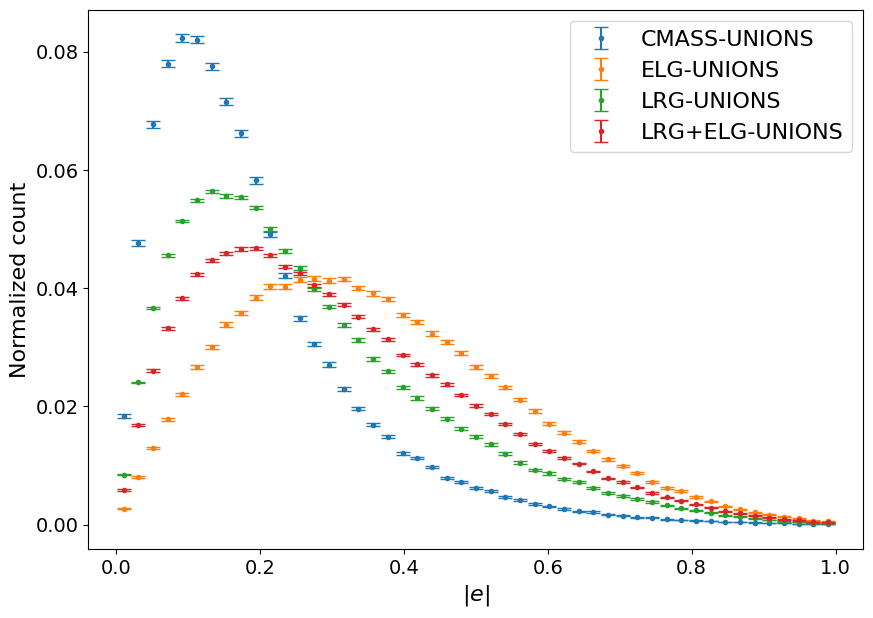

In [12]:
# Plots of summary statistics

e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts_cmass,_ = np.histogram(e_cmass, bins = e_bins) 
e_data_counts_elg,_ = np.histogram(e_elg, bins = e_bins) 
e_data_counts_lrg,_ = np.histogram(e_lrg, bins = e_bins) 
e_data_counts_lrg_elg,_ = np.histogram(e_lrg_elg, bins = e_bins) 

plt.figure( figsize = (10,7))
plt.errorbar(e_cents, e_data_counts_cmass/nb_unions_cmass, yerr=np.sqrt(e_data_counts_cmass) / nb_unions_cmass, fmt='o',markersize=3,label="CMASS-UNIONS", capsize=5)
plt.errorbar(e_cents, e_data_counts_elg/nb_unions_elg, yerr=np.sqrt(e_data_counts_elg) / nb_unions_elg, fmt='o',markersize=3, label="ELG-UNIONS", capsize=5)
plt.errorbar(e_cents, e_data_counts_lrg/nb_unions_lrg, yerr=np.sqrt(e_data_counts_elg) / nb_unions_lrg, fmt='o',markersize=3,label="LRG-UNIONS", capsize=5)
plt.errorbar(e_cents, e_data_counts_lrg_elg/nb_unions_lrg_elg, yerr=np.sqrt(e_data_counts_lrg_elg) / nb_unions_lrg_elg, fmt='o',markersize=3, label="LRG+ELG-UNIONS", capsize=5)
plt.legend(fontsize=16)
plt.xlabel(r"$\vert e \vert$", fontsize=16)
plt.ylabel("Normalized count", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

In [13]:
# Load the posterior of sbi_simulation.ipynb

class CustomPrior:
    pass

posterior = torch.load('posterior.pt', weights_only=False) 

In [14]:
# DATA

e_bins=np.linspace(0,1,50) ; e_cents = (e_bins[1:]+e_bins[:-1])/2.


e_data_counts_cmass,_ = np.histogram(e_cmass, bins = e_bins) 
e_counts_data = [e_data_counts_cmass]
e_counts_data_cmass=np.array(e_counts_data)
x_obs_cmass = e_counts_data_cmass/nb_unions_cmass


e_data_counts_elg,_ = np.histogram(e_elg, bins = e_bins) 
e_counts_data = [e_data_counts_elg]
e_counts_data_elg=np.array(e_counts_data)
x_obs_elg = e_counts_data_elg/nb_unions_elg


e_data_counts_lrg,_ = np.histogram(e_lrg, bins = e_bins) 
e_counts_data = [e_data_counts_lrg]
e_counts_data_lrg=np.array(e_counts_data)
x_obs_lrg = e_counts_data_lrg/nb_unions_lrg


e_data_counts_lrg_elg,_ = np.histogram(e_lrg_elg, bins = e_bins) 
e_counts_data = [e_data_counts_lrg_elg]
e_counts_data_lrg_elg=np.array(e_counts_data)
x_obs_lrg_elg = e_counts_data_lrg_elg/nb_unions_lrg_elg

In [15]:
samples = posterior.sample((30000,), x=x_obs_cmass)
samples_cmass = samples.numpy()
quantiles_cmass = np.quantile(samples_cmass, [1-0.683, 0.683], axis=0)

 
samples = posterior.sample((30000,), x=x_obs_elg)
samples_elg = samples.numpy()
quantiles_elg = np.quantile(samples_elg, [1-0.683, 0.683],  axis=0)


samples = posterior.sample((30000,), x=x_obs_lrg)
samples_lrg = samples.numpy()
quantiles_lrg = np.quantile(samples_lrg, [1-0.683, 0.683],  axis=0)


samples = posterior.sample((30000,), x=x_obs_lrg_elg)
samples_lrg_elg = samples.numpy()
quantiles_lrg_elg = np.quantile(samples_lrg_elg, [1-0.683, 0.683],  axis=0)

Drawing 30000 posterior samples:   0%|          | 0/30000 [00:00<?, ?it/s]

Drawing 30000 posterior samples: 100%|██████████| 30000/30000 [00:00<00:00, 82507.81it/s]


/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_7721/1147650907.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


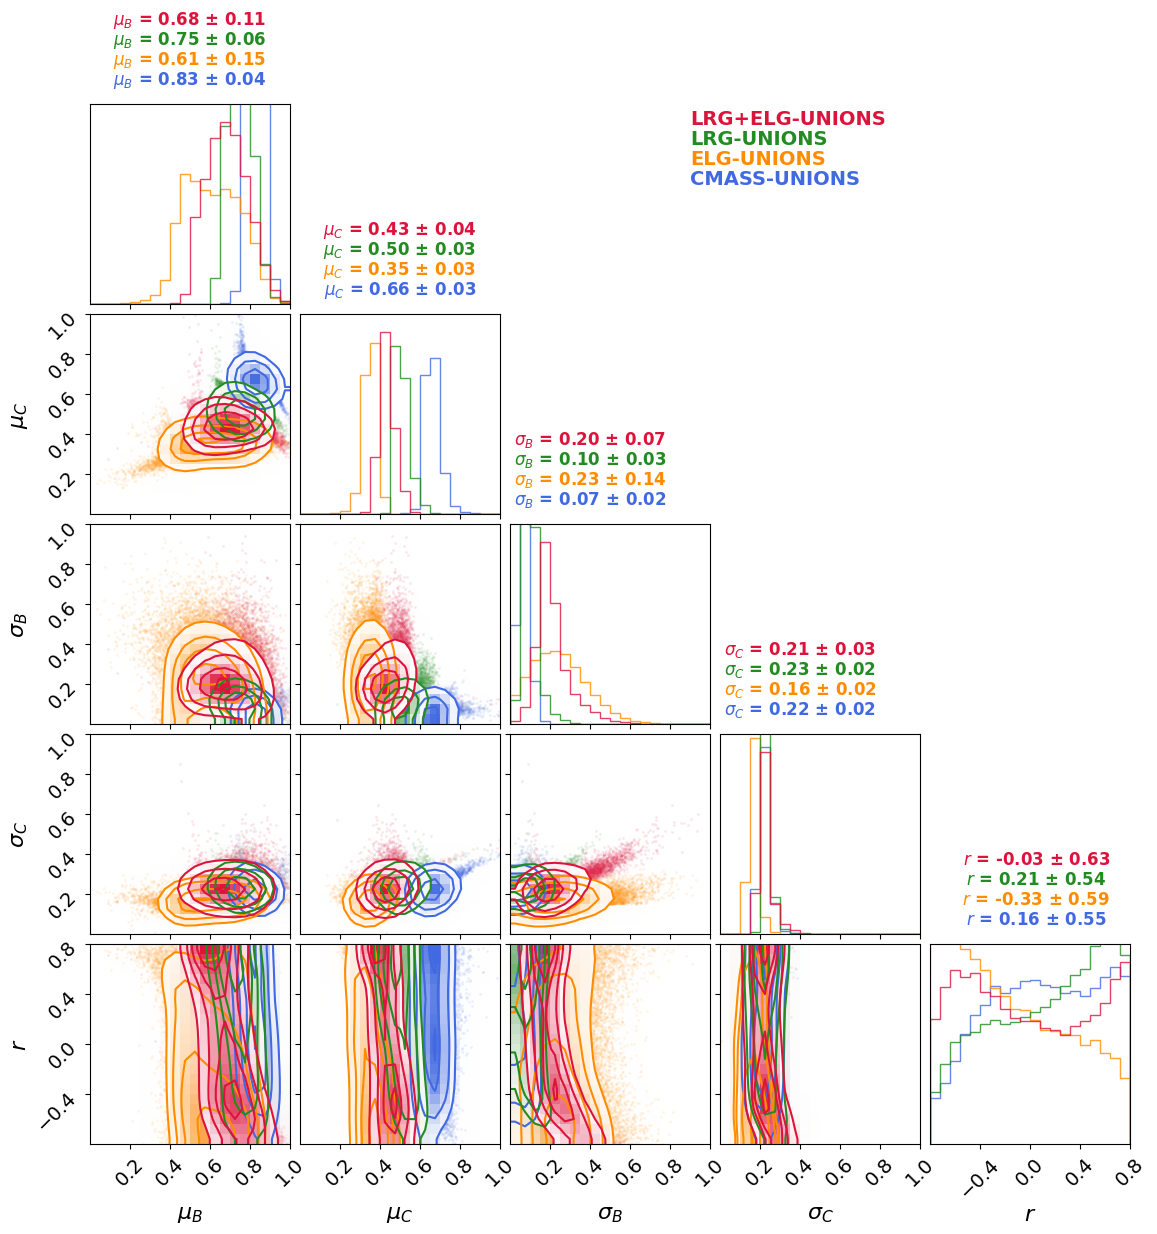

In [36]:
# Contours for the parameters

labels = [r"$\mu_B$", r"$\mu_C$", r"$\sigma_B$", r"$\sigma_C$", r"$r$"]
ranges = [[0, 1], [0, 1], [0, 1], [0, 1], [-0.8, 0.8]]

colors = ["royalblue", "darkorange", "forestgreen", "crimson"]
dataset_labels = ["CMASS-UNIONS", "ELG-UNIONS", "LRG-UNONS", "LRG+ELG-UNIONS"]
samples_list = [samples_cmass, samples_elg, samples_lrg, samples_lrg_elg]

# Créer la figure avec les premiers échantillons (CMASS-UNIONS)
fig = corner.corner(
    samples_cmass,
    labels=labels, 
    range=ranges, 
    show_titles=False, 
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  # Lissage des contours pour un rendu plus propre
    plot_density=True,  # Ajout des contours
    plot_contours=True,  # Tracer les contours de densité
    color=colors[0],
    #quantiles=[0.16, 0.5, 0.84],
    hist_kwargs={"density": True, "alpha": 0.8}
)

# Ajouter les autres jeux de données (ELG-UNIONS et LRG-UNIONS) à la même figure
corner.corner(
    samples_elg, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  # On évite de réécrire les titres à chaque fois
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[1], 
    #quantiles=[0.16, 0.5, 0.84],
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()  # Utilisation de la figure existante
)

corner.corner(
    samples_lrg, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[2], 
    #quantiles=[0.16, 0.5, 0.84],
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()
)


corner.corner(
    samples_lrg_elg, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[3], 
    #quantiles=[0.16, 0.5, 0.84],
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()
)




# Ajouter les annotations pour les légendes des datasets dans la figure
ax = fig.axes[0]  # Prendre le premier axe pour placer les annotations
ax.annotate("CMASS-UNIONS", xy=(3, 0.6), xycoords="axes fraction", color=colors[0], fontsize=14, fontweight="bold")
ax.annotate("ELG-UNIONS", xy=(3, 0.7), xycoords="axes fraction", color=colors[1], fontsize=14, fontweight="bold")
ax.annotate("LRG-UNIONS", xy=(3, 0.8), xycoords="axes fraction", color=colors[2], fontsize=14, fontweight="bold")
ax.annotate("LRG+ELG-UNIONS", xy=(3, 0.9), xycoords="axes fraction", color=colors[3], fontsize=14, fontweight="bold")


# Ajouter les valeurs moyennes et erreurs colorées au-dessus des histogrammes
axes = np.array(fig.axes).reshape((len(labels), len(labels)))

for i in range(len(labels)):
    ax = axes[i, i]
    y_max = ax.get_ylim()[1]
    y_offset = 0.1 * y_max

    for dataset, color, dataset_name in zip(samples_list, colors, dataset_labels):
        median = np.median(dataset[:, i])
        q16, q84 = np.percentile(dataset[:, i], [16, 84])
        err_minus, err_plus = median - q16, q84 - median

        # Adjust x position for specific labels
        x_pos = 0.05  # Default x position
        if labels[i] == r"$\mu_B$":
            x_pos = 0.5  # Center for r
        elif labels[i] == r"$\mu_C$":
            x_pos = 0.5  # Center for r
        elif labels[i] == r"$\sigma_B$":
            x_pos = 0.4  # Center for sigma_C
        elif labels[i] == r"$\sigma_C$":
            x_pos = 0.4  # Center for sigma_C
        elif labels[i] == r"$r$":
            x_pos = 0.05  # Center for r
        

        ax.text(
            x_pos, y_max + y_offset, 
            f"{labels[i]} = {median:.2f} ± {(err_plus + err_minus) / 2:.2f}",
            color=color, fontsize=12, fontweight="bold",
            ha="center", transform=ax.transData
        )
        y_offset += 0.1 * y_max



# Appliquer la taille des ticks pour une meilleure lisibilité
for ax in fig.axes:
    ax.tick_params(labelsize=14)

# Afficher la figure
fig.show()

In [25]:
# MODEL = 3D gaussian population of galaxies defined by a set of eigenvalues and eigenvectors

def population_3D (mu_B, mu_C, sigma_B, sigma_C, r, nb_galaxies) : 
    
    # EIGENVALUES
    A=1
    
    # Random gaussian draw to obtain the axis lengths B,C (= eigenvalues)
    BC2 = np.empty((0, 2))
    while len(BC2) < nb_galaxies:
        BC = np.random.multivariate_normal(mean=[mu_B, mu_C], cov=[[sigma_B**2, r*sigma_B*sigma_C], [r*sigma_B*sigma_C, sigma_C**2]], size=nb_galaxies)
    
        # Priors : B/A<1 ; C/A<1 ; C<B ; C>0 ; B>0
        mask = (BC[:,0]/A<=1) & (BC[:,1]/ A<=1) & (BC[:,0] >= BC[:,1]) & (BC[:,0]>0) & (BC[:,1]>0)
        BC_valid = BC[mask]

        BC2 = np.concatenate((BC2, BC_valid), axis=0)
    
    BC2 = BC2[:nb_galaxies]
    B, C = BC2[:, 0], BC2[:, 1]

    A=np.ones(nb_galaxies)

    evls = np.array([A,B,C])**2 ; evls=np.transpose(evls) # eigenvalues



    # EIGENVECTORS

    # Random orientation angles (quaternions)
    rand_quat = np.random.randn(nb_galaxies,4) ; rand_quat /= np.linalg.norm(rand_quat, axis=1, keepdims=True)
    rotation = Rotation.from_quat(rand_quat) ; euler_angles = rotation.as_euler('ZYX', degrees=True)
    euler_angles_rad = euler_angles*np.pi/180
    psi, theta, phi = euler_angles_rad[:,0], euler_angles_rad[:,1], euler_angles_rad[:,2]

    
    # Rotation matrix that relates the eigenvectors (X,Y,Z) of the galaxies to a frame of reference (x,y,z)
    D = np.zeros((nb_galaxies, 3, 3))

    D[:, 0, 0] = np.cos(theta) * np.cos(psi)
    D[:, 0, 1] = -np.cos(phi) * np.sin(psi) + np.sin(phi) * np.sin(theta) * np.cos(psi)
    D[:, 0, 2] = np.sin(phi) * np.sin(psi) + np.cos(phi) * np.sin(theta) * np.cos(psi)

    D[:, 1, 0] = np.cos(theta) * np.sin(psi)
    D[:, 1, 1] = np.cos(phi) * np.cos(psi) + np.sin(phi) * np.sin(theta) * np.sin(psi)
    D[:, 1, 2] = -np.sin(phi) * np.cos(psi) + np.cos(phi) * np.sin(theta) * np.sin(psi)

    D[:, 2, 0] = -np.sin(theta)
    D[:, 2, 1] = np.sin(phi) * np.cos(theta)
    D[:, 2, 2] = np.cos(phi) * np.cos(theta)

    
    evc0 = np.asarray([[1,0,0],[0,1,0],[0,0,1]]) # Frame of reference (x,y,z)
    evcl = np.einsum('ijk,kl->ijl', D, evc0) # eigenvectors (X,Y,Z)

    return evcl, evls

In [34]:
# SIMULATOR (for simulation-based inference): projection of the 3D galaxies in 2D along the line-of-sight ('y')
# Output = summary statistics = P(e)

# References : 
    # (1) Lamman et al., https://arxiv.org/pdf/2209.03949
    # (2) From Gendzwill D. J., Stauffer M. R., 1981, https://www.researchgate.net/profile/D-Gendzwill/publication/225869829_Analysis_of_triaxial_ellipsoids_Their_shapes_plane_sections_and_plane_projections/links/5aa18aa2a6fdcc22e2d11fc5/Analysis-of-triaxial-ellipsoids-Their-shapes-plane-sections-and-plane-projections.pdf



def simulator(theta, # The parameters of the 3D model (mu_B, mu_C, sigma_B, sigma_C, r)
               nb_galaxies, # The number of galaxies
               p_axis='y', # The direction of projection (here 'y' denotes by convention the direction of the line-of-sight)
               A=1, # The major axis of the galaxies, fixed to 1 in the analysis
               e_bins=np.linspace(0,1,50) # Bins for the histogram of e_counts (output)
               ):


    mu_B, mu_C, sigma_B, sigma_C, r = theta
    

    #Eigenvectors and eigenvalues
    evcl, evls = population_3D (mu_B, mu_C, sigma_B, sigma_C, r, nb_galaxies)
    

    # Projection 3D => 2D
    if p_axis=='x': # Projection perpendicular to the LOS
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y': # Projection along the LOS
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]


    # Coefficients A,B,C
    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)


    # Axis a_p,b_p and orientation angle r_p of the projected galaxy
    r_p = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


    # Projected ellipticity
    e1, e2 = e_complex(a_p, b_p, r_p) ; e = [e1,e2] ; e=np.array(e)


    # Final output = summary statistics = P(e)
    e_counts,_ = np.histogram(np.sqrt(e[0,:]**2+e[1,:]**2),bins=e_bins)
    
    
    return e_counts/nb_galaxies

Best fit CMASS-UNIONS(0.82698107, 0.66349775, 0.06945925, 0.22353582, 0.14551292)
Best fit ELG-UNIONS(0.6106225, 0.3491789, 0.23212744, 0.16442156, -0.28468135)
Best fit LRG-UNIONS(0.75036395, 0.511316, 0.102302425, 0.23178785, 0.14366347)
Best fit LRG+ELG-UNIONS(0.6852724, 0.43680978, 0.21553142, 0.22605176, 0.0083676465)


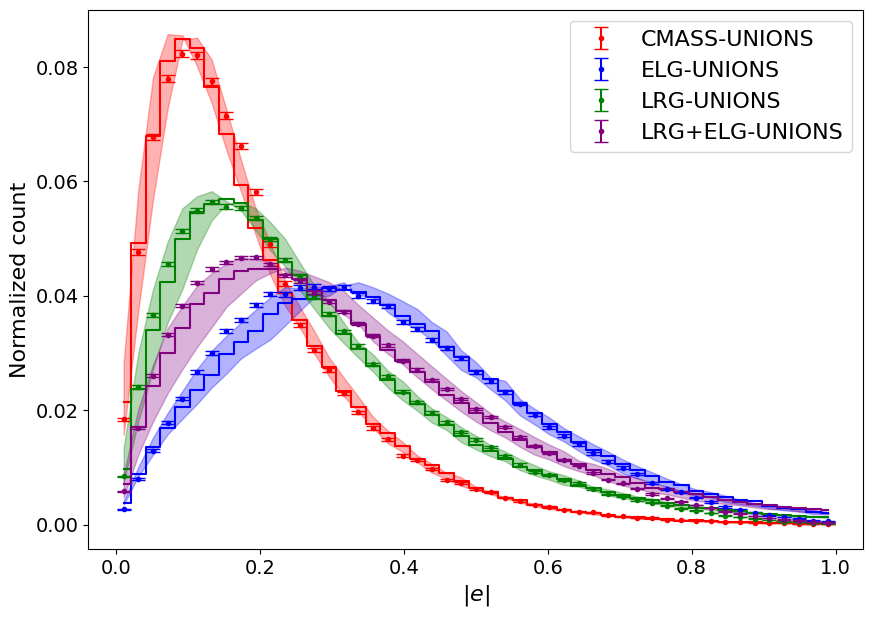

In [35]:
# Best fit obtained after having performed simulation-based inference

theta_estimated=np.mean(samples_cmass, axis=0)
mu_B_cmass, mu_C_cmass, sigma_B_cmass, sigma_C_cmass, r_cmass = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit CMASS-UNIONS{mu_B_cmass, mu_C_cmass, sigma_B_cmass, sigma_C_cmass, r_cmass}")
x_estimated_cmass= simulator([mu_B_cmass, mu_C_cmass, sigma_B_cmass, sigma_C_cmass, r_cmass],nb_galaxies=nb_unions_cmass)
q_lower_cmass = simulator(quantiles_cmass[0],nb_galaxies=nb_unions_cmass) ; q_upper_cmass = simulator(quantiles_cmass[1],nb_galaxies=nb_unions_cmass)


theta_estimated=np.mean(samples_elg, axis=0)
mu_B_elg, mu_C_elg, sigma_B_elg, sigma_C_elg, r_elg = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit ELG-UNIONS{mu_B_elg, mu_C_elg, sigma_B_elg, sigma_C_elg, r_elg}")
x_estimated_elg= simulator([mu_B_elg, mu_C_elg, sigma_B_elg, sigma_C_elg, r_elg],nb_galaxies=nb_unions_elg)
q_lower_elg = simulator(quantiles_elg[0],nb_galaxies=nb_unions_elg) ; q_upper_elg = simulator(quantiles_elg[1],nb_galaxies=nb_unions_elg)


theta_estimated=np.mean(samples_lrg, axis=0)
mu_B_lrg, mu_C_lrg, sigma_B_lrg, sigma_C_lrg, r_lrg = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit LRG-UNIONS{mu_B_lrg, mu_C_lrg, sigma_B_lrg, sigma_C_lrg, r_lrg}")
x_estimated_lrg= simulator([mu_B_lrg, mu_C_lrg, sigma_B_lrg, sigma_C_lrg, r_lrg],nb_galaxies=nb_unions_lrg)
q_lower_lrg = simulator(quantiles_lrg[0],nb_galaxies=nb_unions_lrg) ; q_upper_lrg = simulator(quantiles_lrg[1],nb_galaxies=nb_unions_lrg)


theta_estimated=np.mean(samples_lrg_elg, axis=0)
mu_B_lrg_elg, mu_C_lrg_elg, sigma_B_lrg_elg, sigma_C_lrg_elg, r_lrg_elg = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit LRG+ELG-UNIONS{mu_B_lrg_elg, mu_C_lrg_elg, sigma_B_lrg_elg, sigma_C_lrg_elg, r_lrg_elg}")
x_estimated_lrg_elg= simulator([mu_B_lrg_elg, mu_C_lrg_elg, sigma_B_lrg_elg, sigma_C_lrg_elg, r_lrg_elg],nb_galaxies=nb_unions_lrg_elg)
q_lower_lrg_elg = simulator(quantiles_lrg_elg[0],nb_galaxies=nb_unions_lrg_elg) ; q_upper_lrg_elg = simulator(quantiles_lrg_elg[1],nb_galaxies=nb_unions_lrg_elg)




plt.figure( figsize = (10,7) )


plt.plot(e_cents,x_estimated_cmass,drawstyle='steps-mid',  linestyle='-',color='red')
plt.errorbar(e_cents, e_data_counts_cmass/nb_unions_cmass, yerr=np.sqrt(e_data_counts_cmass) / nb_unions_cmass, fmt='o',markersize=3, capsize=5, label='CMASS-UNIONS', color='red')
plt.fill_between(e_cents, q_lower_cmass, q_upper_cmass, color='red', alpha=0.3)


plt.plot(e_cents,x_estimated_elg,drawstyle='steps-mid', linestyle='-',color='blue')
plt.errorbar(e_cents, e_data_counts_elg/nb_unions_elg, yerr=np.sqrt(e_data_counts_elg) / nb_unions_elg, fmt='o', markersize=3, capsize=5, label='ELG-UNIONS', color='blue')
plt.fill_between(e_cents, q_lower_elg, q_upper_elg, color='blue', alpha=0.3)


plt.plot(e_cents,x_estimated_lrg,drawstyle='steps-mid', linestyle='-',color='green')
plt.errorbar(e_cents, e_data_counts_lrg/nb_unions_lrg, yerr=np.sqrt(e_data_counts_lrg) / nb_unions_lrg, fmt='o', markersize=3, capsize=5, label='LRG-UNIONS', color='green')
plt.fill_between(e_cents, q_lower_lrg, q_upper_lrg, color='green', alpha=0.3)


plt.plot(e_cents,x_estimated_lrg_elg,drawstyle='steps-mid', linestyle='-',color='purple')
plt.errorbar(e_cents, e_data_counts_lrg_elg/nb_unions_lrg_elg, yerr=np.sqrt(e_data_counts_lrg_elg) / nb_unions_lrg_elg, fmt='o', markersize=3, capsize=5, label='LRG+ELG-UNIONS', color='purple')
plt.fill_between(e_cents, q_lower_lrg_elg, q_upper_lrg_elg, color='purple', alpha=0.3)





plt.legend(fontsize=16)
plt.xlabel(r"$\vert e \vert$", fontsize=16)
plt.ylabel("Normalized count", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

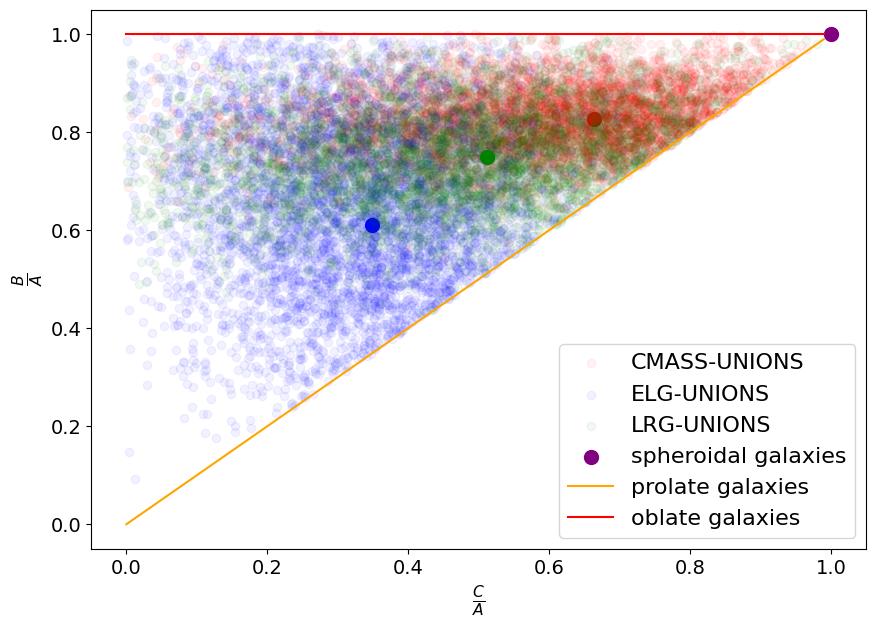

In [ ]:
# 3D population of galaxies constrained for the different surveys

nb_galaxies=nb_unions_cmass; A=1
BC = np.random.multivariate_normal(mean=[mu_B_cmass,mu_C_cmass],cov=[[sigma_B_cmass**2,r_cmass*sigma_B_cmass*sigma_C_cmass],[r_cmass*sigma_B_cmass*sigma_C_cmass,sigma_C_cmass**2]],size=nb_galaxies)
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC_cmass = BC[mask]


nb_galaxies=nb_unions_elg; A=1
BC = np.random.multivariate_normal(mean=[mu_B_elg,mu_C_elg],cov=[[sigma_B_elg**2,r_elg*sigma_B_elg*sigma_C_elg],[r_elg*sigma_B_elg*sigma_C_elg,sigma_C_elg**2]],size=nb_galaxies)
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC_elg = BC[mask]


nb_galaxies=nb_unions_lrg; A=1
BC = np.random.multivariate_normal(mean=[mu_B_lrg,mu_C_lrg],cov=[[sigma_B_lrg**2,r_lrg*sigma_B_lrg*sigma_C_lrg],[r_lrg*sigma_B_lrg*sigma_C_lrg,sigma_C_lrg**2]],size=nb_galaxies)
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC_lrg = BC[mask]




plt.figure( figsize = (10,7) )


plt.scatter(BC_cmass[:5000,1]/A,BC_cmass[:5000,0]/A,alpha=0.05,label = 'CMASS-UNIONS',color='red')
plt.scatter([mu_C_cmass],[mu_B_cmass],color='red', s=100)

plt.scatter(BC_elg[:5000,1]/A,BC_elg[:5000,0]/A,alpha=0.05,label = 'ELG-UNIONS',color='blue')
plt.scatter([mu_C_elg],[mu_B_elg],color='blue', s=100)

plt.scatter(BC_lrg[:5000,1]/A,BC_lrg[:5000,0]/A,alpha=0.05,label = 'LRG-UNIONS',color='green')
plt.scatter([mu_C_lrg],[mu_B_lrg],color='green', s=100)


plt.scatter([1], [1], color='purple', label='spheroidal galaxies', s=100)

x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='orange',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='red',label='oblate galaxies')

plt.xlabel(r"$\frac{C}{A}$",fontsize=16) ; plt.ylabel(r"$\frac{B}{A}$",fontsize=16)

plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)